# Image Segmentation

Source 1: "https://pytorch.org/vision/master/auto_examples/others/plot_visualization_utils.html#instance-seg-output"

Source 2: "https://www.youtube.com/watch?v=f8iiTSCZ9FU" / "https://colab.research.google.com/drive/1b3TwHdeWAgmZ7n1eOFbzVw1T0oZvC9U6?usp=sharing#scrollTo=FM9O_ErdtmGo"

In [1]:
import torch
import torchvision

In [2]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

C:\Users\antoa\anaconda3\envs\EsercLu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\antoa\anaconda3\envs\EsercLu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
#model = model.cuda() #Comment this line if no GPU

In [4]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

#len(COCO_INSTANCE_CATEGORY_NAMES) # 91 classes including background

In [5]:
from PIL import Image
from torchvision import transforms as T
import numpy as np
import requests
from io import BytesIO
# the io and requests libraries are just for loading images from URLS

Possiamo caricare l'immagine da un sito (tramite URL) o da una cartella locale.

Andiamo comunque a convertirla in tensore e poi a normalizzare (con "transform"), così da ottenere la previsione dal "model". Da questo otterremo:

- le stime di appartenenza ad una specifica classe, che andremo a filtrare con pred_t in base al threshold da noi imposto (prendendoci gli indici relativi)
- selezioniamo tutte le box, classi e maschere prendendole prima dalla lista-dizionario della predizione e filtrandolo con gli indici relativi di pred_t

N.B.

Tensor.detach() method in PyTorch is used to separate a tensor from the computational graph by returning a new tensor that doesn’t require a gradient. If we want to move a tensor from the Graphical Processing Unit (GPU) to the Central Processing Unit (CPU), then we can use detach() method.

Tensor.numpy() ritorna il tensore d'interesse in un array di dimensione n.

Tensor.squeeze() restituisce il vettore interessato senza l'eventuale dimensione unitaria (Ax1xB -> AxB)

In [6]:
def get_prediction(img_path, threshold=0.5, url=False):
  if url: # We have to request the image
    response = requests.get(img_path)
    img = Image.open(BytesIO(response.content))
  else:
    img = Image.open(img_path) # This is for local images
  transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  img = transform(img)
  #img = img.cuda() # Only if GPU, otherwise comment this line
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  #Let's change it to GPU
  # pred = pred.cpu() # We will just send predictions back to CPU
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

Le due righe con % sono delle "magic command" di jupyter:

la prima permette di visualizzare i grafici generati con Matplotlib direttamente all'interno delle celle del notebook stesso

la seconda aumenta la risoluzione dei grafici visualizzati nel notebook, rendendoli più nitidi e ad alta definizione.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high res images

Ci ha messo un casino a scaricarsi OpenCV...

OpenCV è una enorme libreria open source per la visione artificiale, l'apprendimento automatico e l'elaborazione delle immagini. Può elaborare immagini e video per identificare oggetti, volti o persino la calligrafia di un essere umano.

In [8]:
import cv2 # opencv

np.asarray converte l'input in un array con data type 8-bit unsigned integer

cv2.imdecode converte un dato immagine da una memory cache e la converte in formato immagine con i suoi colori reali (con cv2.IMREAD_COLOR)

In [9]:
from urllib.request import urlopen
def url_to_image(url, readFlag=cv2.IMREAD_COLOR):
  resp = urlopen(url) # We want to convert URL to cv2 image here, so we can draw the mask and bounding boxes
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, readFlag)
  return image

In [10]:
import random

Funzione per ottenere un colore random della maschera dell'oggetto riconosciuto

In [11]:
def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

cv2.cvtColor converte l'immagine ottenuta dalla funzione precedente dallo spazio dei colori BGR  a RGB. Si pone poi sull'immagine le maschere con colore random.

cv2.addWeighted sovrappone all'immagine, la maschera colorata (con un certo peso che rappresenta la sfumatura della maschera stessa). le ultime riche pongono il rettangolo relativo alla maschera con il testo della classe identificata

In [16]:
def instance_segmentation(img_path, threshold=0.5, rect_th=3,
                          text_size=1, text_th=3, url=False):
  masks, boxes, pred_cls = get_prediction(img_path, threshold=threshold, url=url)
  if url:
    img = url_to_image(img_path) # If we have a url image
  else: # Local image
    img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    pt1 = tuple(int(x) for x in boxes[i][0])
    pt2 = tuple(int(x) for x in boxes[i][1])
    cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks[i]

In [17]:
# I will link the following image in the description
# We are going to try the function out, first we will download an image
#!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O car.jpg

In [18]:
img, pred_classes, masks = instance_segmentation('img_ID/One_day.jpg', rect_th=5, text_th=4)

[{'boxes': tensor([[444.0312, 114.3945, 589.1138, 526.5057],
        [296.4428,  85.7406, 444.3264, 522.3253],
        [643.2986, 350.3098, 792.2050, 540.5898],
        [498.1399, 197.1359, 586.2039, 342.5872],
        [545.1810, 297.8937, 579.2632, 341.2716],
        [529.8459, 255.7823, 580.3150, 340.1863],
        [640.6299, 365.2874, 783.7349, 541.7471],
        [545.4573, 272.1865, 599.4156, 341.2810],
        [444.1251, 285.4329, 453.7283, 301.7935],
        [448.2160, 295.3873, 456.0400, 303.7974],
        [444.3916, 285.4626, 453.8684, 300.2484],
        [502.4108, 256.4581, 604.2870, 344.2872],
        [446.1911, 289.6186, 455.5536, 302.9573],
        [639.2519, 365.3689, 786.1061, 542.5693],
        [537.2582, 211.7609, 572.1436, 349.2201]], grad_fn=<StackBackward0>), 'labels': tensor([ 1,  1, 18, 31, 31, 31, 19, 31, 77, 77, 85, 31, 77, 21, 31]), 'scores': tensor([0.9999, 0.9998, 0.9589, 0.8979, 0.4566, 0.4520, 0.3746, 0.3632, 0.2241,
        0.1248, 0.1220, 0.1171, 0.0840, 0

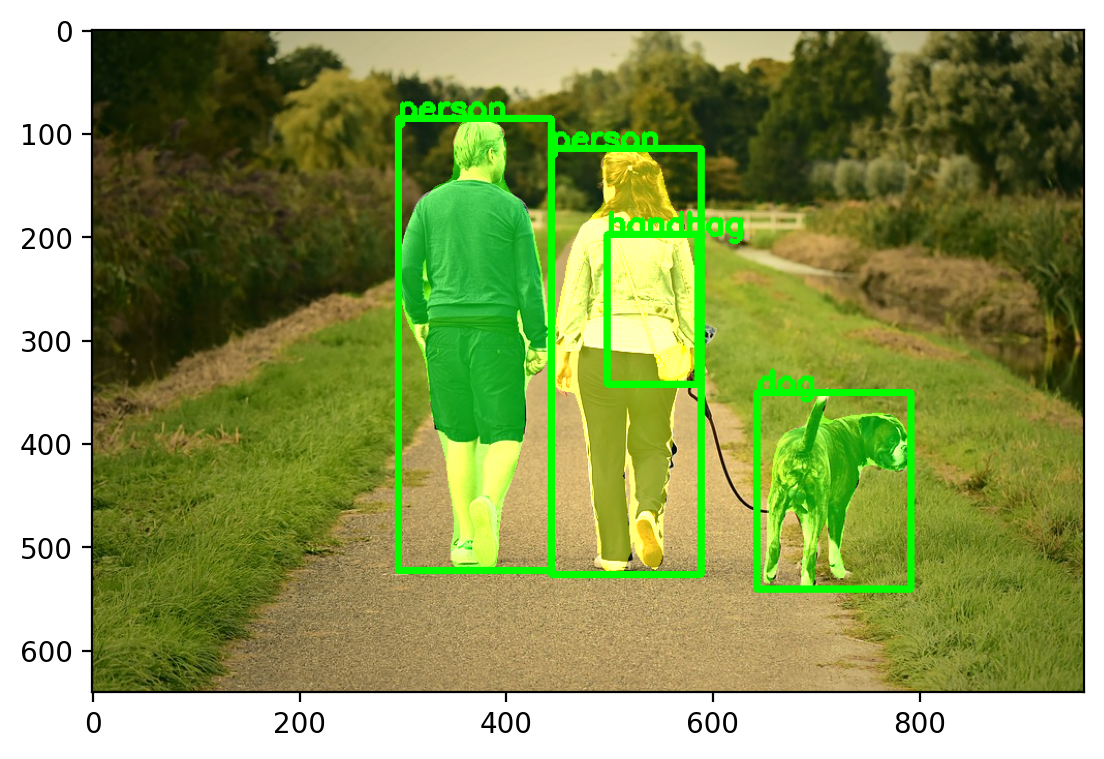

In [19]:
plt.imshow(img)
plt.show()